In [1]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist


Using TensorFlow backend.


In [2]:
batch_size = 100
original_dim = 784
latent_dim = 4
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

In [3]:
x = Input(batch_shape=(batch_size, original_dim))
x1 = BatchNormalization()(x)
h = Dense(intermediate_dim, activation='relu')(x1)
b1 = BatchNormalization()(h)
z_mean = Dense(latent_dim)(b1)
z_log_var = Dense(latent_dim)(b1)
z_mean1 = BatchNormalization()(z_mean)
z_log_var1 = BatchNormalization()(z_log_var)


def sampling(args):
    z_mean1, z_log_var1 = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean1 + K.exp(z_log_var1 / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean1, z_log_var1])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var1 - K.square(z_mean1) - K.exp(z_log_var1), axis=-1)
    return K.mean(xent_loss + kl_loss)

#y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (100, 784)            3136                                         
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960                                       
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (100, 256)            1024                                         
___________________________________________________________________________________________

In [4]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(np.prod(x_test.shape[1:]))
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + (original_dim,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + (original_dim,))

print(x_train.shape)
print(x_test.shape)

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

## build a model to project inputs on the latent space
encoder = Model(x, z_mean)

784
(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s - loss: 189.7650 - val_loss: 163.1030
Epoch 2/20
60000/60000 [==============================] - 4s - loss: 159.7192 - val_loss: 153.1223
Epoch 3/20
60000/60000 [==============================] - 4s - loss: 152.1396 - val_loss: 147.5262
Epoch 4/20
60000/60000 [==============================] - 4s - loss: 147.7289 - val_loss: 144.0202
Epoch 5/20
60000/60000 [==============================] - 4s - loss: 144.6806 - val_loss: 141.4600
Epoch 6/20
60000/60000 [==============================] - 4s - loss: 142.3499 - val_loss: 139.4390
Epoch 7/20
60000/60000 [==============================] - 4s - loss: 140.7156 - val_loss: 137.9897
Epoch 8/20
60000/60000 [==============================] - 4s - loss: 139.4437 - val_loss: 136.8413
Epoch 9/20
60000/60000 [==============================] - 4s - loss: 138.4424 - val_loss: 135.9927
Epoch 10/20
60000/60000 [====

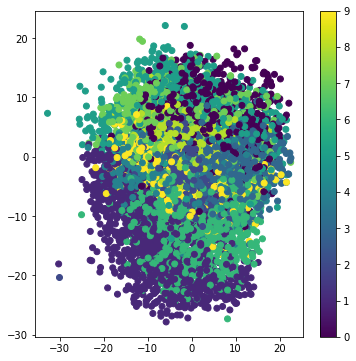

In [5]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

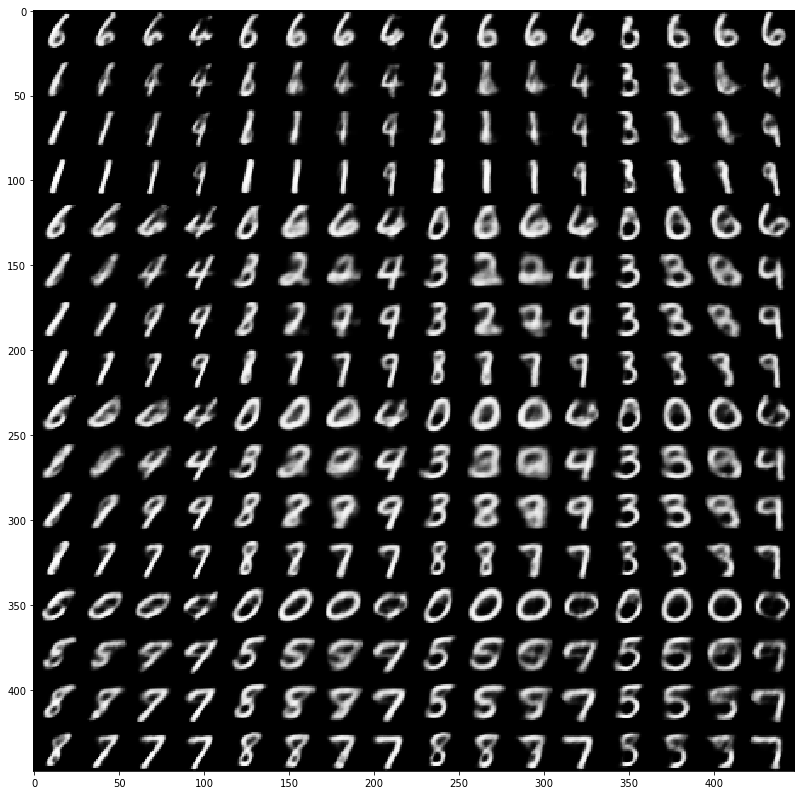

In [6]:
# display a 2D manifold of the digits
n = 4  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n * n, digit_size * n * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_xx = norm.ppf(np.linspace(0.05, 0.95, n))
grid_yy = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        for ii, yii in enumerate(grid_xx):
            for jj, xii in enumerate(grid_yy):
                z_sample = np.array([[xi, yi, xii, yii]])
                z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 4)
                x_decoded = generator.predict(z_sample, batch_size=batch_size)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                
                x = (i * n + ii) * digit_size
                y = (j * n + jj) * digit_size
                figure[x:x + digit_size, y:y + digit_size] = digit

plt.figure(figsize=(14, 14))
plt.imshow(figure, cmap='Greys_r')
plt.show()